## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---


## Briefly state how you computed the camera matrix and distortion coefficients. Provide an example of a distortion corrected calibration image.

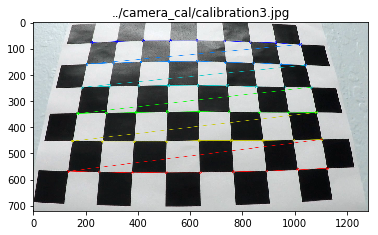

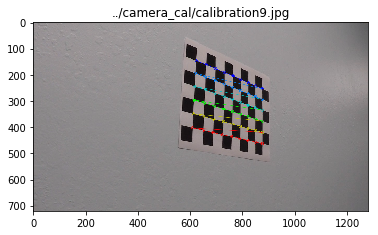

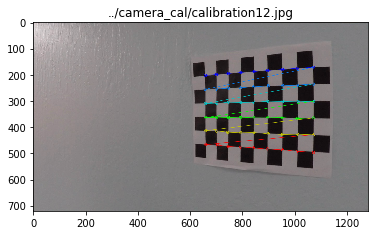

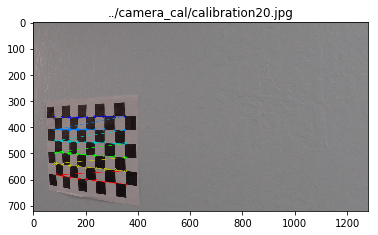

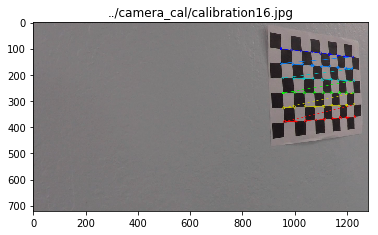

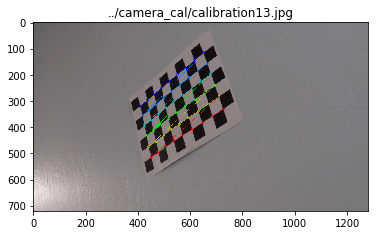

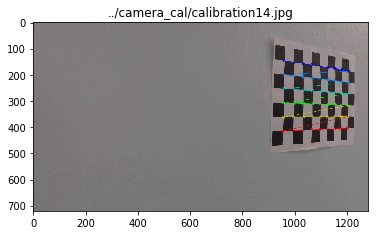

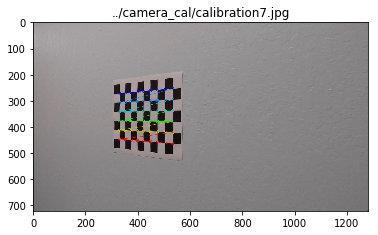

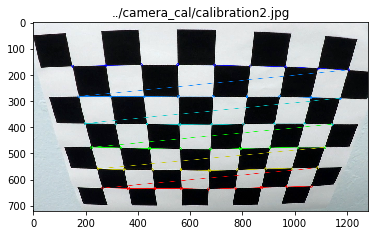

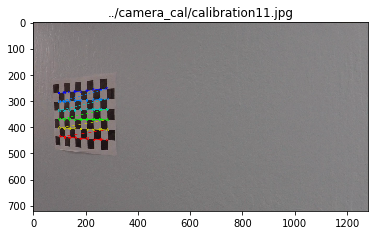

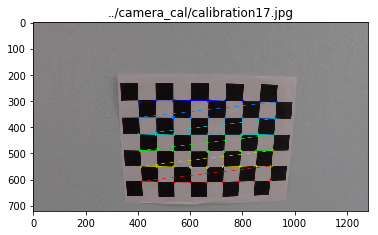

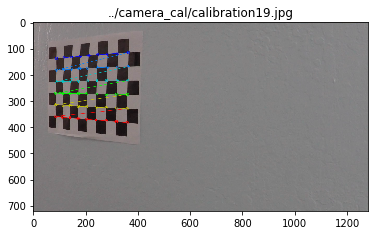

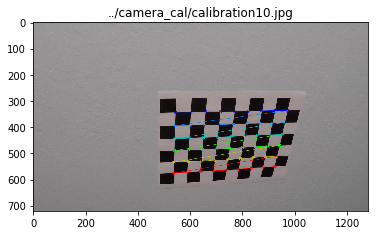

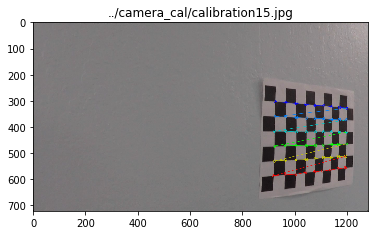

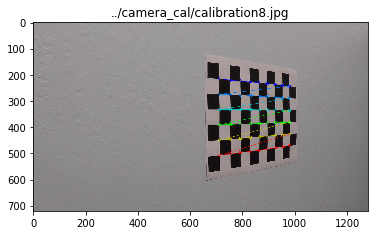

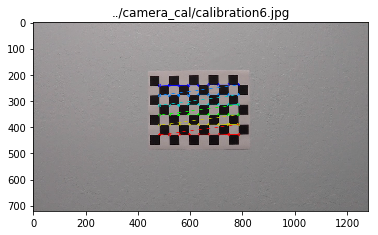

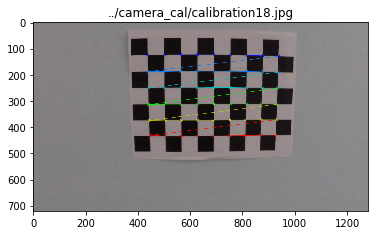

In [206]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob

images = glob.glob('../camera_cal/calibration*.jpg')

#store objectpoints and image points
objpoints = []
imgpoints=[]

# corner dimensions
nx = 9
ny = 6

# prepare object points
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2) # x, y coordinates


for fname in images:
    img = cv2.imread(fname)

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners of 8x6 corner chess board
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    # If found, draw corners
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
        
        # Draw and display the corners - just for visualisation
        cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        plt.title(fname)
        plt.imshow(img)
        plt.show()



### Provide an example of a distortion-corrected image.
    

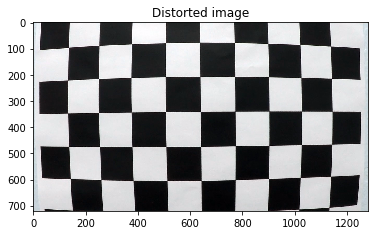

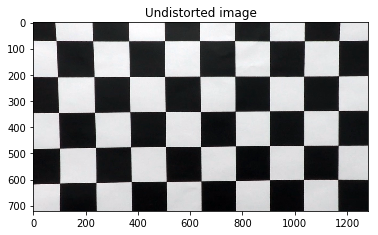

In [103]:
ret = None
mtx = None
dist = None
rvecs = None
tvecs = None

# create undistorting function that uses above object points and imagepoints
def cal_undistort(img_p, objpoints_p, imgpoints_p):
    img = cv2.cvtColor(img_p, cv2.COLOR_RGB2GRAY)
    ret_p, mtx_p, dist_p, rvecs_p, tvecs_p = cv2.calibrateCamera(objpoints_p, imgpoints_p, img_p.shape[1:], None, None)
    ret = ret_p
    mtx  = mtx_p
    dist = dist_p
    rvecs = rvecs_p
    tvecs = tvecs_p
    undist = cv2.undistort(img_p, mtx_p, dist_p, None, mtx_p)
    return undist

# pick a sample image and undistort
filename = 'calibration1.jpg'
img = cv2.imread('../camera_cal/'+filename)
plt.title("Distorted image")
plt.imshow(img)
plt.show()
undistored = cal_undistort(img, objpoints, imgpoints)
plt.imshow(undistored)
plt.title("Undistorted image")
plt.savefig('../output_images/undistored_'+filename)
plt.show()
        

### Describe how (and identify where in your code) you used color transforms, gradients or other methods to create a thresholded binary image. Provide an example of a binary image result.


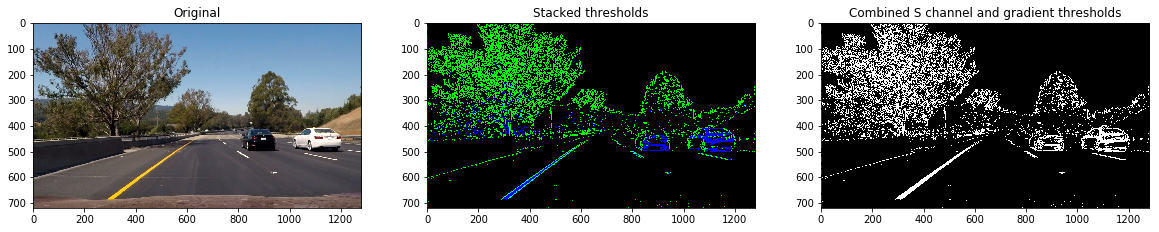

In [207]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg



def threshold_binary_image(img, grad_thresh=(0, 255), color_thresh=(0,255)):
    # Convert to HLS color space and separate the S channel
    # Note: img is the undistorted image
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]

    # Grayscale image
    # NOTE: we already saw that standard grayscaling lost color information for the lane lines
    # Explore gradients in other colors spaces / color channels to see what might work better
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    thresh_min = grad_thresh[0]#20
    thresh_max =  grad_thresh[1]#100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Threshold color channel
    s_thresh_min = color_thresh[0]#170
    s_thresh_max = color_thresh[1]#255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    return color_binary, combined_binary

filename = "test6.jpg"
image = mpimg.imread('../test_images/'+filename)
color_binary, combined_binary = threshold_binary_image(image, grad_thresh=(20,100), color_thresh=(170,255))

# Plotting thresholded images
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
ax1.set_title('Original')
ax1.imshow(image)

ax2.set_title('Stacked thresholds')
ax2.imshow(color_binary)

ax3.set_title('Combined S channel and gradient thresholds')
ax3.imshow(combined_binary, cmap='gray')
plt.imsave('../output_images/threshold_binary_'+filename, combined_binary,cmap='gray')


### Describe how (and identify where in your code) you performed a perspective transform and provide an example of a transformed image.

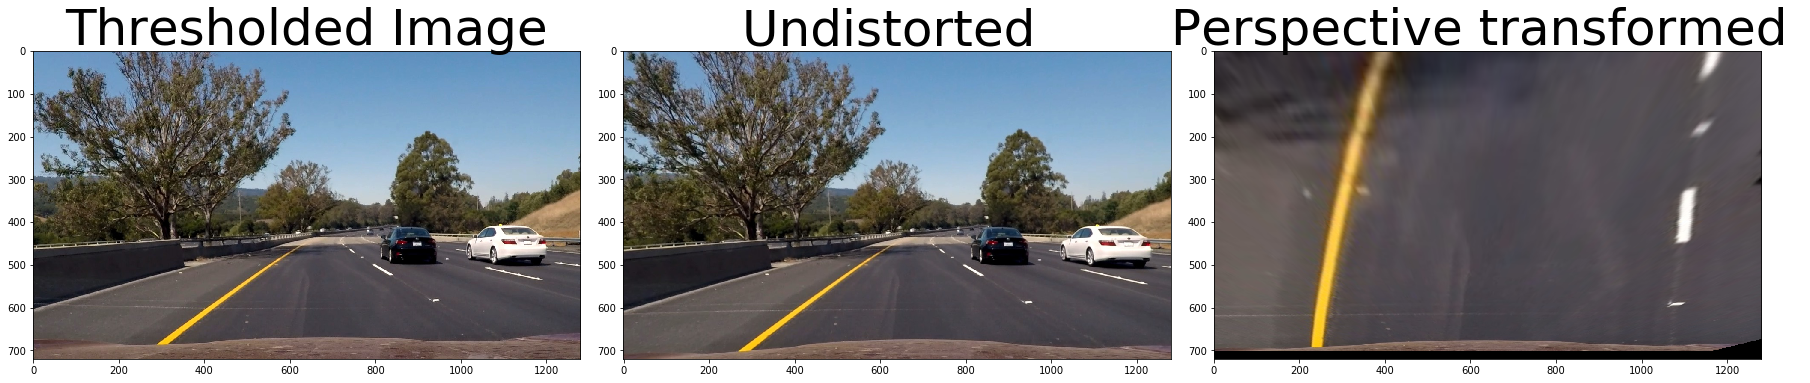

In [112]:
def undistort_and_warp(img):        
    undistored = cal_undistort(img, objpoints, imgpoints)    
    img_size = (undistored.shape[1], undistored.shape[0])
#     src = np.float32(
#         [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
#         [((img_size[0] / 6) - 10), img_size[1]],
#         [(img_size[0] * 5 / 6) + 55, img_size[1]],
#         [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
#     dst = np.float32(
#         [[(img_size[0] / 4), 0],
#         [(img_size[0] / 4), img_size[1]],
#         [(img_size[0] * 3 / 4), img_size[1]],
#         [(img_size[0] * 3 / 4), 0]])

#     src = np.float32(
#          [[595, 450],
#          [203, 720],
#          [1127, 720],
#          [685, 450]])

#     dst = np.float32(
#          [[320, 0],
#          [320, 720],
#          [960, 720],
#          [960, 0]])

    src = np.float32([[568, 468], [715, 468], [1040, 680], [270, 680]])
    dst = np.float32([[200, 0], [1000, 0], [1000, 680], [200, 680]])
   
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(undistored, M, img_size, flags = cv2.INTER_LINEAR)    
    return undistored, warped

# # filename = "straight_lines1.jpg"
# # image = mpimg.imread('../test_images/'+filename)
# filename = "threshold_binary_test6.jpg"
# image = mpimg.imread('../output_images/'+filename)

filename = "test6.jpg"
image = mpimg.imread('../test_images/'+filename)
undistored, warped = undistort_and_warp(image)
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Thresholded Image', fontsize=50)

ax2.imshow(undistored)
ax2.set_title('Undistorted ', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

ax3.imshow(warped)
ax3.set_title('Perspective transformed ', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

plt.imsave('../output_images/threshold_binary_warped_'+filename, warped,cmap='gray')

### Describe how (and identify where in your code) you identified lane-line pixels and fit their positions with a polynomial?

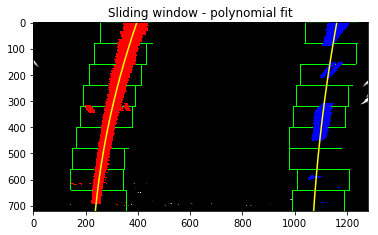

In [107]:

import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2

# Load our image
binary_warped = mpimg.imread('../output_images/threshold_binary_warped_threshold_binary_test6.jpg')

def find_lane_pixels(binary_warped_p):
    binary_warped = cv2.cvtColor(binary_warped_p, cv2.COLOR_RGB2GRAY)
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)   
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

left_fitx_result = None
right_fit_result = None

def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
            
    return out_img, left_fitx, right_fitx, ploty, left_fit, right_fit

out_img, left_fitx, right_fitx, ploty, left_fit, right_fit = fit_polynomial(binary_warped)

plt.title("Sliding window - polynomial fit")
plt.imshow(out_img)

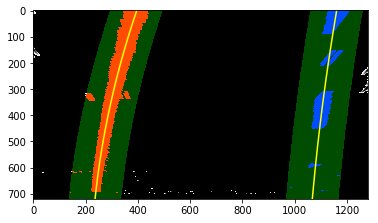

In [194]:
binary_warped = mpimg.imread('../output_images/threshold_binary_warped_threshold_binary_test6.jpg')
# Polynomial fit values from the previous frame
# Make sure to grab the actual values from the previous step in your project!
#left_fit = np.array([ 2.13935315e-04, -3.77507980e-01,  4.76902175e+02])
#right_fit = np.array([4.17622148e-04, -4.93848953e-01,  1.11806170e+03])

def fit_poly(img_shape, leftx, lefty, rightx, righty):
     ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

def search_around_poly(binary_warped_p):
    binary_warped = cv2.cvtColor(binary_warped_p, cv2.COLOR_RGB2GRAY)
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return result, ploty, left_fit, right_fit

# Run image through the pipeline
# Note that in your project, you'll also want to feed in the previous fits
result, ploty, left_fit, right_fit = search_around_poly(binary_warped)

# View your output
plt.imshow(result)
plt.imsave('../output_images/threshold_binary_warped_'+filename, result,cmap='gray')

### Describe how (and identify where in your code) you calculated the radius of curvature of the lane and the position of the vehicle with respect to center.

In [195]:
binary_warped = mpimg.imread('../output_images/threshold_binary_warped_threshold_binary_test6.jpg')
# Polynomial fit values from the previous frame
# Make sure to grab the actual values from the previous step in your project!
#left_fit = np.array([ 2.13935315e-04, -3.77507980e-01,  4.76902175e+02])
#right_fit = np.array([4.17622148e-04, -4.93848953e-01,  1.11806170e+03])

def fit_poly_real(img_shape, leftx, lefty, rightx, righty):
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
     ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fit_cr, right_fit_cr, ploty

def search_around_poly(binary_warped_p):
    binary_warped = cv2.cvtColor(binary_warped_p, cv2.COLOR_RGB2GRAY)
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fit_cr, right_fit_cr, ploty = fit_poly_real(binary_warped.shape, leftx, lefty, rightx, righty)   
    
    
    return left_fit_cr, right_fit_cr, ploty

# Run image through the pipeline
# Note that in your project, you'll also want to feed in the previous fits
left_fit_cr, right_fit_cr, ploty = search_around_poly(binary_warped)

def measure_curvature_pixels():
    '''
    Calculates the curvature of polynomial functions in pixels.
    '''
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    return left_curverad, right_curverad


# Calculate the radius of curvature in pixels for both lane lines
left_curverad, right_curverad = measure_curvature_pixels()

def measure_curvature_real():
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return left_curverad, right_curverad

left_curve, right_curve = measure_curvature_pixels()
print(left_curve, 'pixels', right_curverad, 'pixels')

# Calculate the radius of curvature in meters for both lane lines
left_curverad, right_curverad = measure_curvature_real()

print(left_curverad, 'm', right_curverad, 'm')



2947.34994402 pixels 6356.95689772 pixels
1009.56506333 m 2899.6820968 m


### Provide an example image of your result plotted back down onto the road such that the lane area is identified clearly.

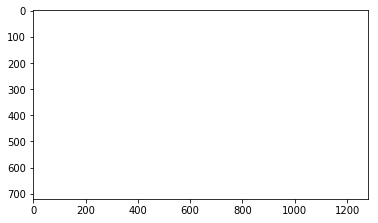

In [196]:

import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# calibration matrix and distortion coefficients
# mtx = mtx
mtx = None
dist = None
# dist = dist
binary_warped = mpimg.imread('../output_images/threshold_binary_warped_threshold_binary_test6.jpg')
filename = "test6.jpg"
undist = mpimg.imread('../test_images/'+filename)

def warp_back_perspective(binary_warped, mtx, dist):
    img_size = (image.shape[1], image.shape[0])
    dst = np.float32([[568, 468], [715, 468], [1040, 680], [270, 680]])
    src = np.float32([[200, 0], [1000, 0], [1000, 680], [200, 680]])
    offset = 100
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warp_back = cv2.warpPerspective(binary_warped, M, img_size, flags=cv2.INTER_LINEAR)
    return warp_back, M



warp_zero = np.zeros_like(binary_warped).astype(np.uint8)


points_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
points_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
points = np.hstack((points_left, points_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(warp_zero, np.int_([points]), (0,255, 0))
cv2.polylines(warp_zero, np.int_([points_left]), False, (255, 0, 0), thickness=20)
cv2.polylines(warp_zero, np.int_([points_right]), False, (0, 0, 255), thickness=20)
# Warp the blank back to original image space using inverse perspective matrix (Minv)
# newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
# warp_back, M = warp_back_perspective(warp_zero, mtx, dist)
# Combine the result with the original image
# print("undist.shape()"+str(undist.shape))
# print("warp_back.shape()"+str(warp_back[].shape))
# result = cv2.addWeighted(undist, 1, warp_back, 0.3, 0)


plt.imshow(warp_zero)
plt.show()


(720, 1280, 3)


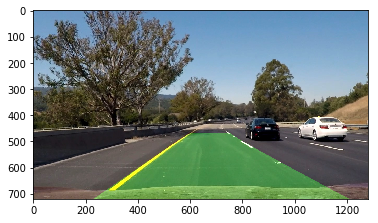

In [225]:

filename = "test6.jpg"
undist = mpimg.imread('../test_images/'+filename)

def distort_and_unwarp(img):        
    undistored = cal_undistort(img, objpoints, imgpoints)    
    img_size = (undistored.shape[1], undistored.shape[0])
    src = np.float32([[200, 0], [1000, 0], [1000, 680], [200, 680]])
    dst = np.float32([[568, 468], [715, 468], [1040, 680], [270, 680]])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(undistored, M, img_size, flags = cv2.INTER_LINEAR)    
    return undistored, warped


# Create an image to draw the lines on 
binary_warped = mpimg.imread('../output_images/threshold_binary_warped_threshold_binary_test6.jpg')

warp_zero = np.zeros_like(binary_warped[:,:,0]).astype(np.uint8) 
color_warp = np.dstack((warp_zero, warp_zero, warp_zero)) 
# Recast the x and y points into usable format for cv2.fillPoly() 
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))]) 
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))]) 
pts = np.hstack((pts_left, pts_right)) 
# Draw the lane onto the warped blank image 

cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0)) 
# Warp the blank back to original image space using inverse perspective matrix (Minv) 
undistored, warped = distort_and_unwarp(color_warp)
print(warped.shape)
# # Combine the result with the original image 
result = cv2.addWeighted(undist, 1, warped, 0.3, 0) 
plt.imshow(result)